In [4]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from einops import rearrange

from src.ldae import TADMLitModel
import yaml

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/kdang/projects/spartDM
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir: /home/kdang/projects/spartDM


## Helper functions

In [2]:
import torchvision

# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

from src.utils.visualization import plot_comparison_starmen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


# Data loader

In [3]:
from src.data.datamodules import StarmenDataset
from monai.data import DataLoader
from monai.data.utils import first

train_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="train",
    nb_subject=None,
)

test_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="test",
    nb_subject=None,
)

growing_circle_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="growing_circle20",
    nb_subject=None,
)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=1)

one_batch = first(iter(train_loader))

test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)

growing_circle_loader = DataLoader(growing_circle_ds, batch_size=1, shuffle=True, num_workers=1)

# Load conDDPM model


In [2]:
# Load model

# CondDDPM model

from src.ldae import CondDDPM
from lightning.pytorch.utilities.model_summary import ModelSummary


WORK_DIR = "workdir/diffae_starmen"
# WORK_DIR = "workdir/debug"

## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)
encoder = diffae_litmodel.ema_encoder
encoder.eval()
ema_decoder = diffae_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = diffae_litmodel.gaussian_diffusion

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


# TADM model

## Test Init from litmodel

In [33]:
from src.ldae import TADMLitModel
import yaml

with open("configs/starmen_tadm.yaml", "r") as file:
    args = yaml.safe_load(file)


tadm_args = args["test"]["model"]["init_args"]
tadm_args["test_ddim_style"] = "ddim1"
tadm_args

{'spartial_dim': 2,
 'mode': 'tadm',
 'pretrained_path': '${fit.trainer.logger.init_args.save_dir}/pretrain/checkpoints/best.ckpt',
 'args': {'sr_scale': 1,
  'use_attn': False,
  'res': True,
  'up_input': False,
  'use_wn': False,
  'weight_init': False,
  'use_rrdb': True,
  'fix_rrdb': False,
  'rrdb_num_block': 8,
  'rrdb_num_feat': 64},
 'timesteps_args': {'timesteps': 1000, 'betas_type': 'linear'},
 'lr': 2.5e-05,
 'ema_decay': 0.999,
 'ema_update_after_step': 10,
 'log_img_every_epoch': 10,
 'test_ddim_style': 'ddim1',
 'test_noise_level': 250}

In [34]:

tadm_litmodel = TADMLitModel(**tadm_args)
encoder = tadm_litmodel.encoder
encoder
decoder = tadm_litmodel.decoder
decoder

TADMUnet(
  (cond_proj): ConvTranspose2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (time_pos_emb): SinusoidalPosEmb()
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Mish()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_diff_ages): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_age): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_patient_condition): Sequential(
          (0): Mish()
          (1): Linear(in_features=64, out_features=32, bias=True)
        )
        (block1): Block(
          (block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            

## Normal init

In [3]:
from src.tadm.models.unet import TADMUnet, RRDBNet


import argparse

hparams = argparse.Namespace(
    rrdb_num_block=True,
    sr_scale=1, 
)

hparams = {
   "sr_scale":1,
   "use_attn": False, 
   "res": True,
   "up_input": False,
   "use_wn": False,
   "weight_init": False,
    "use_rrdb": True,
    "fix_rrdb": False, 
    "rrdb_num_block": 8,
    "rrdb_num_feat": 64,
    "rrdb_ckpt": '',
}


tadm_unet = TADMUnet(dim=32, out_dim=1, dim_mults=(1, 2, 2, 4), cond_dim=hparams['rrdb_num_feat'], hparams=hparams)
tadm_unet.downs[0]

if hparams['use_rrdb']:
    rrdb_net = RRDBNet(1, 1, hparams['rrdb_num_feat'], hparams['rrdb_num_block'],
                    hparams['rrdb_num_feat'] // 2, hparams=hparams)


In [4]:
print(type(tadm_unet.downs))
for i, mod in tadm_unet.downs.named_children():
    mod_list = []
    for idx, module in enumerate(mod):
        mod_list.append(module.__class__.__name__)
    print(f"{i}: {type(mod)} - {mod_list}")

# check the dim
dim =  32
dim_mults = [1, 2, 2, 4]
dims = [1, *map(lambda m: dim * m, dim_mults)]
print(dims)

test = tadm_unet.downs[1]
test

<class 'torch.nn.modules.container.ModuleList'>
0: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
1: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
2: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
3: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Identity']
[1, 32, 64, 64, 128]


ModuleList(
  (0): ResnetBlock(
    (mlp): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_diff_ages): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_age): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_patient_condition): Sequential(
      (0): Mish()
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (block1): Block(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): Mish()
      )
    )
    (block2): Block(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): Mish()
      )
    )
    (res_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): ResnetBlock(
    (mlp): Sequential(
      (0): 

## Load pretrained model

In [5]:
from lightning.pytorch.utilities.model_summary import ModelSummary


ckpt_path = "workdir/diffae_starmen/tadm/checkpoints/best.ckpt"

ckpt = torch.load(ckpt_path, map_location=torch.device("cpu"))
ckpt

tadm_litmodel = TADMLitModel.load_from_checkpoint(ckpt_path, map_location=device)

print(ModelSummary(tadm_litmodel, max_depth=1))

  | Name        | Type     | Params | Mode 
-------------------------------------------------
0 | encoder     | RRDBNet  | 5.9 M  | train
1 | decoder     | TADMUnet | 2.4 M  | train
2 | ema_encoder | RRDBNet  | 5.9 M  | eval 
3 | ema_decoder | TADMUnet | 2.4 M  | eval 
-------------------------------------------------
8.3 M     Trainable params
8.3 M     Non-trainable params
16.6 M    Total params
66.462    Total estimated model params size (MB)
614       Modules in train mode
614       Modules in eval mode


In [141]:
# diff age - age
b, t, c, h, w = 2, 10, 1, 64, 64
emb_dim = 512
dm_age = torch.randn(t)

dm_age_emb = tadm_unet.time_pos_emb(dm_age)
dm_age_emb.shape

x =torch.randn(t, 3, h, w)
img_lr = torch.randn(t, c, h, w)
img_hr = torch.randn(t, c, h, w)

In [144]:
# Extract feature with RRDB Net

rrdb_net.eval()
with torch.no_grad():
    rrdb_out, cond = rrdb_net(img_lr, True)

print(f"rrdb_out: {rrdb_out.shape}")
print(f"cond: {len(cond)}")

for i, c in enumerate(cond):
    print(f"cond [{i}]: {c.shape}")

# cond = tadm_unet.cond_proj(torch.cat(cond[2::3], 1))
# cond.shape

rrdb_out: torch.Size([10, 1, 64, 64])
cond: 9
cond [0]: torch.Size([10, 64, 64, 64])
cond [1]: torch.Size([10, 64, 64, 64])
cond [2]: torch.Size([10, 64, 64, 64])
cond [3]: torch.Size([10, 64, 64, 64])
cond [4]: torch.Size([10, 64, 64, 64])
cond [5]: torch.Size([10, 64, 64, 64])
cond [6]: torch.Size([10, 64, 64, 64])
cond [7]: torch.Size([10, 64, 64, 64])
cond [8]: torch.Size([10, 64, 64, 64])


In [147]:
# cond = torch.randn(t, 3, h ,w)
time = torch.randn(t)
time_emb = tadm_unet.time_pos_emb(time)
time_emb = tadm_unet.mlp(time_emb)

x = img_hr - img_lr
x_noise = x + torch.randn_like(x)

noise_pred = tadm_unet(x=x_noise, 
                       time=time, 
                       cond=cond, 
                       img_lr_up=img_lr, 
                       diff_ages=dm_age, 
                       age=dm_age)


noise_pred.shape

torch.Size([10, 1, 64, 64])

## Train 1 batch 


## Select pair of current and previous scan

In [10]:
img_lr = one_batch["x_origin"][:, :-1, ...]
print(img_lr.shape)

img_hr = one_batch["x_origin"][:, 1:, ...]
print(img_hr.shape)

# sanity check
check = img_hr[:, :-1, ...] == img_lr[:, 1:, ...]
torch.all(check)

# Get the age of prior images
ages = one_batch["age"][:, :-1, ...]
ages.shape

diff_ages = torch.diff(one_batch["age"])
diff_ages.shape

## sanity check
print(one_batch["age"][0])
print(diff_ages[0])

# rearrange tensor from b t to (b t)
img_hr = rearrange(img_hr, "b t ... -> (b t) ...")
img_lr = rearrange(img_lr, "b t ... -> (b t) ...")
diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
ages = rearrange(ages, "b t ... -> (b t) ...")
img_lr_up = img_lr.clone()

torch.Size([2, 9, 1, 64, 64])
torch.Size([2, 9, 1, 64, 64])
tensor([-6.3200, -5.3700, -4.4300, -3.4900, -2.5400, -1.6000, -0.6600,  0.2900,
         1.2300,  2.1700])
tensor([0.9500, 0.9400, 0.9400, 0.9500, 0.9400, 0.9400, 0.9500, 0.9400, 0.9400])


## Select randomly a pair img_lr and img_hr for each patient in a batch

In [25]:
x0 = one_batch["x_origin"]
x0.shape

all_ages = one_batch["age"]
all_ages.shape

# sample two distinct indices and sort them
b, t = all_ages.shape

idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])

# Ensure a < b
idx, _ = torch.sort(idx, dim=1)

batch_idx = torch.arange(b)
img_lr = x0[batch_idx, idx[:,0]]  # (20, 1, 64, 64)
img_hr = x0[batch_idx, idx[:,1]]  # (20, 1, 64, 64)
img_lr_up = img_lr.clone()

ages = all_ages[batch_idx, idx[:, 0]]
ages_hr = all_ages[batch_idx, idx[:, 1]]
diff_ages = ages_hr - ages

diff_ages.shape

torch.Size([20])

## Training step

In [37]:
# Extract representation from RRDB

b, *_, device = *img_hr.shape, img_hr.device

hparams = tadm_litmodel.args
self = tadm_litmodel

t = torch.randint(0, 1000, (b,), device=device).long() 
if hparams['use_rrdb']:
    if hparams['fix_rrdb']:
        self.encoder.eval()
        with torch.no_grad():
            rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out, cond = self.encoder(img_lr, True)
else:
    rrdb_out = img_lr_up
    cond = img_lr


# x = img_hr - img_lr
# out = tadm_unet(x, t, cond, img_lr_up, diff_ages=diff_ages, patient_condition=None, age=ages)

# out.shape

In [39]:
# Train by GaussianDiffusion class

out = self.gaussian_diffusion.regular_train_tadm_one_batch(
    denoise_fn=self.decoder,
    x_0=img_hr - img_lr_up, 
    ages=ages,
    diff_ages=diff_ages,
    condition=cond
)

out

{'prediction_loss': tensor(1.0172, grad_fn=<MeanBackward0>)}

## Sampling for TADM

In [14]:
x_pred = gaussian_diffusion.regular_tadm_sample(
    ddim_style="ddim10",
    encoder=rrdb_net,
    unet=tadm_unet,
    x_0=img_lr_up,
    x_T=torch.randn_like(img_lr_up),
    z=cond,
    diff_ages=diff_ages,
    ages=ages,
    disable_tqdm=False,
)

x_pred.shape

sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


torch.Size([18, 1, 64, 64])

# TADMLitModel Test step

## Load model from checkpoint

In [7]:
from src.ldae import TADMLitModel

WORK_DIR = "workdir/diffae_starmen"
# WORK_DIR = "workdir/debug"

## Load model
ckpt_path = os.path.join(WORK_DIR, "tadm", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tadm_litmodel = TADMLitModel.load_from_checkpoint(ckpt_path, map_location=device)
encoder = tadm_litmodel.ema_encoder
encoder.eval()
ema_decoder = tadm_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = tadm_litmodel.gaussian_diffusion

In [8]:
from monai.losses import PerceptualLoss

tadm_litmodel.lpips = PerceptualLoss(
    spatial_dims=tadm_litmodel.spartial_dim,
    network_type="squeeze",
    is_fake_3d=True if tadm_litmodel.spartial_dim == 3 else False,
    fake_3d_ratio=0.5,
)
tadm_litmodel.lpips = tadm_litmodel.lpips.to(tadm_litmodel.device)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Select data

In [57]:
batch = first(iter(test_loader))

self = tadm_litmodel

## Test steps

In [80]:
# subject metadata
pidx = batch["id"].item()
anomaly = batch["anomaly"].item()
anomaly_type = batch["anomaly_type"][0]
anomaly_gt_seg = batch["anomaly_gt_seg"]

x0 = batch["x_origin"]
img_lr = x0[:, :-1, ...]
img_hr = x0[:, 1:, ...]
img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
img_lr_up = img_lr.clone()  # just to align with TADM source code. 

# ages and diff ages
ages = batch["age"][:, :-1, ...]
diff_ages = torch.diff(batch["age"])
diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
ages = rearrange(ages, "b t ... -> (b t) ...")


In [59]:

# 1. Encoder image using RRDB network
if self.args['use_rrdb']:
    self.encoder.eval()
    rrdb_out, cond = self.encoder(img_lr, True)
else:
    rrdb_out = img_lr_up
    cond = img_lr

# 2. Sampling x from trained TADMUnet
x_pred = self.gaussian_diffusion.regular_tadm_sample(
    ddim_style="ddim10",
    encoder=self.encoder,
    unet=self.decoder,
    x_0=img_lr_up,
    x_T=torch.randn_like(img_lr_up),
    z=cond,
    diff_ages=diff_ages,
    ages=ages,
    disable_tqdm=False,
)

sampling loop time step: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


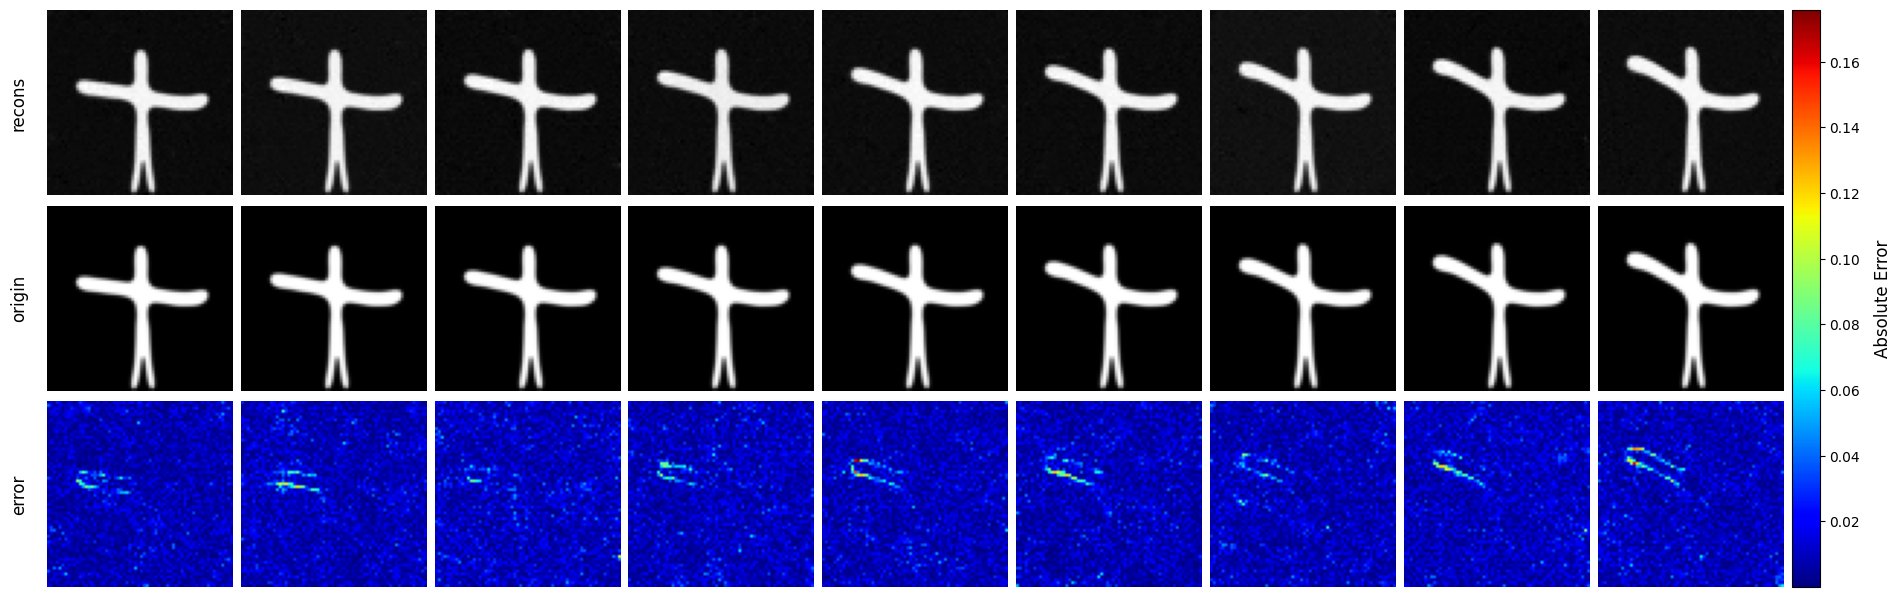

In [63]:
img_pred = img_lr_up + x_pred

fig = plot_comparison_starmen(
    imgs=[img_pred.squeeze(), img_hr.squeeze(), torch.abs(img_hr-img_pred).squeeze()],
    labels=["recons", "origin", "error"],
    is_errors=[False, False, True]
)

### Metrics

In [91]:

eval_dict = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

ssim_metric = self.ssim(img_pred, img_hr).mean().item()
mssim_metric = self.mssim(img_pred, img_hr).mean().item()
psnr_metric = self.psnr(img_pred, img_hr).mean().item()
l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
lpips_metric = self.lpips(img_pred, img_hr)

# write to eval dict
eval_dict["ids"].append(pidx)
eval_dict["ages"].append(ages.cpu().numpy())
eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
eval_dict["ssim_metric"].append(ssim_metric)
eval_dict["mssim_metric"].append(mssim_metric)
eval_dict["psnr_metric"].append(psnr_metric)
eval_dict["lpips_metric"].append(lpips_metric)
eval_dict["l1err"].append(l1err)
eval_dict["l2err"].append(l2err)

eval_dict

{'ids': [184],
 'ages': [array([-2.1 , -1.18, -0.26,  0.66,  1.59,  2.51,  3.43,  4.35,  5.28],
        dtype=float32)],
 'diff_ages': [array([0.91999996, 0.91999996, 0.92      , 0.93      , 0.91999996,
         0.9200001 , 0.91999984, 0.9300003 , 0.9199996 ], dtype=float32)],
 'ssim_metric': [0.727310061454773],
 'mssim_metric': [0.9910882115364075],
 'psnr_metric': [37.18603515625],
 'l1err': [0.010189846158027649],
 'l2err': [0.0001922042720252648],
 'lpips_metric': [tensor(0.0337, grad_fn=<MeanBackward0>)]}

### function

In [98]:
@torch.no_grad()
def tadm_test_step_previous(self, batch, eval_dict, return_fig = False):
    """
    TADM test step using the previous scan as signal to predict the current scan
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"]
    img_lr = x0[:, :-1, ...]
    img_hr = x0[:, 1:, ...]
    img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
    img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
    img_lr_up = img_lr.clone()  # just to align with TADM source code. 

    # ages and diff ages
    ages = batch["age"][:, :-1, ...]
    diff_ages = torch.diff(batch["age"])
    diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
    ages = rearrange(ages, "b t ... -> (b t) ...")

    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim10",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

    # 3. Reconstruc future image
    img_pred = img_lr_up + x_pred

    # Calculate eval metrics
    ssim_metric = self.ssim(img_pred, img_hr).mean().item()
    mssim_metric = self.mssim(img_pred, img_hr).mean().item()
    psnr_metric = self.psnr(img_pred, img_hr).mean().item()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
    lpips_metric = self.lpips(img_pred, img_hr).item()

    # write to eval dict
    eval_dict["ids"].append(pidx)
    eval_dict["ages"].append(ages.cpu().numpy())
    eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
    eval_dict["ssim_metric"].append(ssim_metric)
    eval_dict["mssim_metric"].append(mssim_metric)
    eval_dict["psnr_metric"].append(psnr_metric)
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err)
    eval_dict["l2err"].append(l2err)

    # Plot comparison
    if return_fig: 
        fig = plot_comparison_starmen(
            imgs=[img_pred.squeeze(), img_hr.squeeze(), torch.abs(img_hr-img_pred).squeeze()],
            labels=["recons", "origin", "error"],
            is_errors=[False, False, True],
            opt={
                "title": "Predict current scan using previous scan (jump 1 timestep)"
            }
        )
        return eval_dict, fig
    else:
        return eval_dict
    

sampling loop time step: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


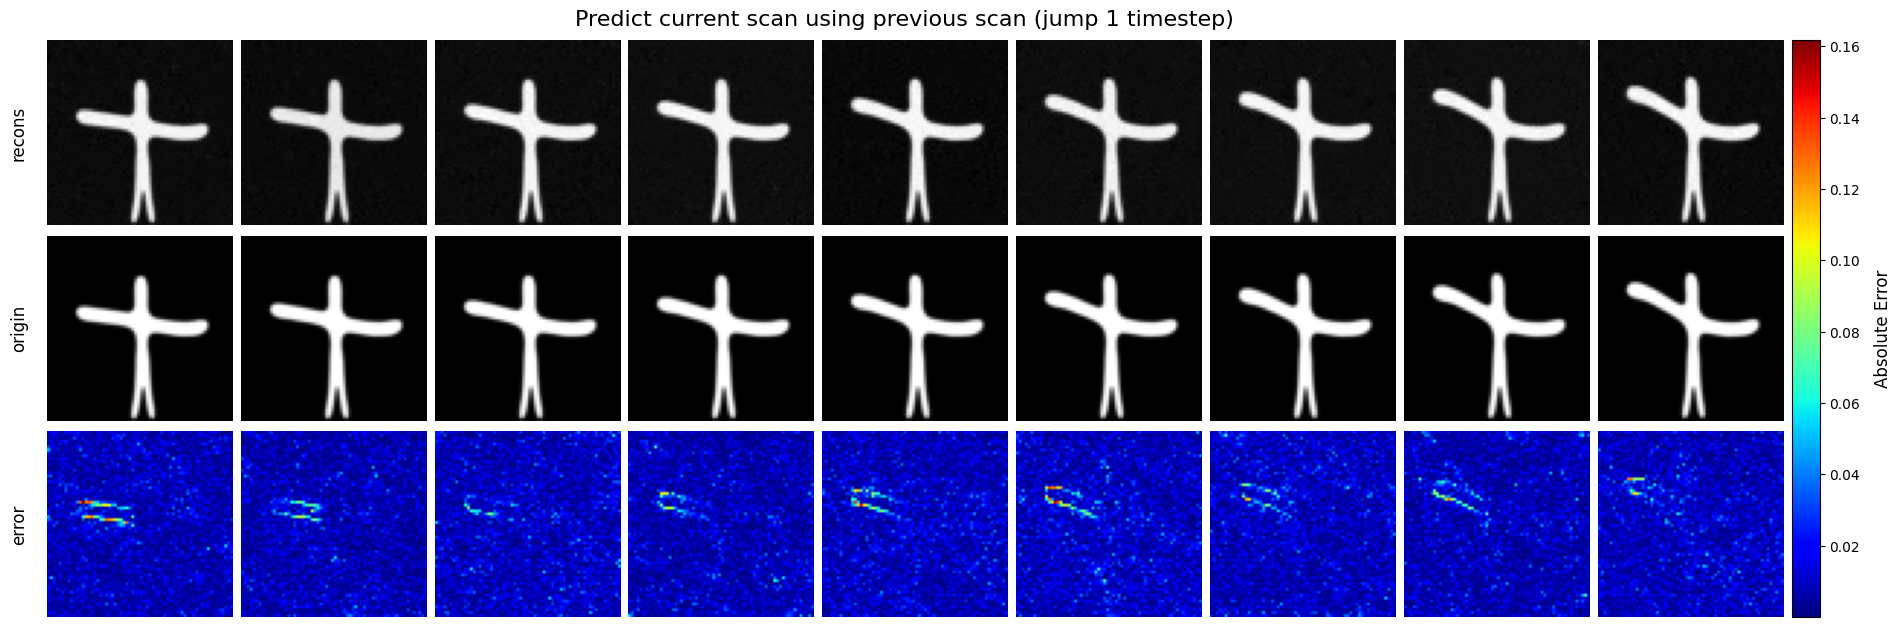

In [99]:
eval_dict_previous = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

eval_dict_previous, fig = tadm_test_step_previous(self, batch, eval_dict_previous, return_fig=True)

In [101]:
eval_dict_previous

{'ids': [184],
 'ages': [array([-2.1 , -1.18, -0.26,  0.66,  1.59,  2.51,  3.43,  4.35,  5.28],
        dtype=float32)],
 'diff_ages': [array([0.91999996, 0.91999996, 0.92      , 0.93      , 0.91999996,
         0.9200001 , 0.91999984, 0.9300003 , 0.9199996 ], dtype=float32)],
 'ssim_metric': [0.7498295307159424],
 'mssim_metric': [0.9911800026893616],
 'psnr_metric': [37.20084762573242],
 'l1err': [0.010003644973039627],
 'l2err': [0.0001927232660818845],
 'lpips_metric': [0.03333181142807007]}

## Select random pair

In [120]:
x0 = batch["x_origin"]
x0.shape

all_ages = batch["age"]
all_ages.shape

# sample two distinct indices and sort them
b, t = all_ages.shape

nb_pair = 2
for i in range(nb_pair):
    idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])
    idx, _ = torch.sort(idx, dim=1)  # ensure a < b

    batch_idx = torch.arange(b)
    x = x0[batch_idx, idx[:,0]]  # (b, 1, 64, 64)
    x_target = x0[batch_idx, idx[:,1]]  # (b, 1, 64, 64)
    img_lr_up = img_lr.clone()

    age = all_ages[batch_idx, idx[:, 0]]
    age_target = all_ages[batch_idx, idx[:, 1]]
    diff_age = age_target - age

    if i == 0:
        img_lr = x
        img_hr = x_target
        ages = age
        diff_ages = diff_age
    else:
        img_lr = torch.cat((img_lr, x))
        img_hr = torch.cat((img_hr, x_target))
        ages = torch.cat((ages, age))
        diff_ages = torch.cat((diff_ages, diff_age))
        
img_lr_up = img_lr.clone()

print(all_ages)
print(idx)
print(diff_ages)
print(ages)

tensor([[-2.1000, -1.1800, -0.2600,  0.6600,  1.5900,  2.5100,  3.4300,  4.3500,
          5.2800,  6.2000]])
tensor([[4, 7]])
tensor([2.7700, 2.7600])
tensor([3.4300, 1.5900])


In [121]:
with torch.no_grad():
    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim5",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

sampling loop time step: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


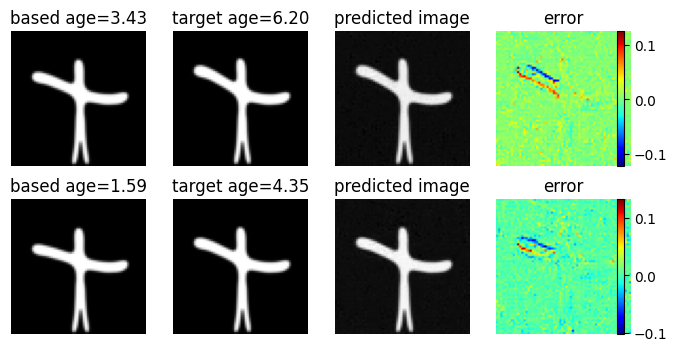

In [ ]:
img_pred = img_lr_up + x_pred
img_pred.shape

l1err = torch.abs(img_hr - img_pred)

img_plots = torch.concat((img_hr[[0]].squeeze(), 
                          img_pred[[0]].squeeze(),
                          l1err[[0]].squeeze()), dim=1)
img_plots.shape

b = img_pred.shape[0]

fig, axes = plt.subplots(b, 4, figsize=(8, b*2))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for ax in axes.flatten():
    ax.axis("off")

for i in range(b):
    # based image
    ax = axes[i, 0]
    ax.imshow(img_lr_up[i].squeeze(), cmap="gray")
    ax.set_title(f"based age={ages[i]:.2f}")

    # taret image
    ax = axes[i, 1]
    ax.imshow(img_hr[i].squeeze(), cmap="gray")
    ax.set_title(f"target age={ages[i] + diff_ages[i]:.2f}")

    # recons image
    ax = axes[i, 2]
    ax.imshow(img_pred[i].squeeze(), cmap="gray")
    ax.set_title(f"predicted image")

    # diff
    ax = axes[i, 3]
    diff_img = img_hr[i] - img_pred[i]
    im = ax.imshow(diff_img.squeeze(), cmap="jet")
    ax.set_title("error")
    cax = inset_axes(ax,
                    width="5%",   # width relative to ax
                    height="100%",  # full height
                    loc='right',
                    )  
    fig.colorbar(im, cax=cax)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

### eval metrics

In [146]:
ssim_metric = self.ssim(img_pred, img_hr).cpu().numpy().squeeze()
mssim_metric = self.mssim(img_pred, img_hr).cpu().numpy().squeeze()
psnr_metric = self.psnr(img_pred, img_hr).cpu().numpy().squeeze()
l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="none").cpu().numpy()
l2err = torch.nn.functional.mse_loss(img_pred, img_hr, reduction="none").cpu().numpy()
l1err = np.mean(l1err, axis=(2, 3)).squeeze()
l2err = np.mean(l2err, axis=(2, 3)).squeeze()
lpips_metric = []
for i in range(img_pred.shape[0]):
    lpips_img = self.lpips(img_hr[[i]], img_pred[[i]])
    lpips_metric.append(lpips_img.item())

lpips_metric

[0.02949407324194908, 0.03481532633304596]

In [152]:
test = [pidx] * nb_pair
test

[184, 184]

### function


In [202]:
@torch.no_grad()
def tadm_test_step_random_pair(self, batch, eval_dict, return_fig = False, nb_pair=1):
    """
    TADM test step using a random pair from a batch
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"]
    img_lr = x0[:, :-1, ...]
    img_hr = x0[:, 1:, ...]
    img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
    img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
    img_lr_up = img_lr.clone()  # just to align with TADM source code. 

    # ages and diff ages
    all_ages = batch["age"]

    # select a random pair
    # sample two distinct indices and sort them
    b, t = all_ages.shape

    for i in range(nb_pair):
        idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])
        idx, _ = torch.sort(idx, dim=1)  # ensure a < b

        batch_idx = torch.arange(b)
        x = x0[batch_idx, idx[:,0]]  # (b, 1, 64, 64)
        x_target = x0[batch_idx, idx[:,1]]  # (b, 1, 64, 64)

        age = all_ages[batch_idx, idx[:, 0]]
        age_target = all_ages[batch_idx, idx[:, 1]]
        diff_age = age_target - age

        if i == 0:
            img_lr = x
            img_hr = x_target
            ages = age
            diff_ages = diff_age
        else:
            img_lr = torch.cat((img_lr, x))
            img_hr = torch.cat((img_hr, x_target))
            ages = torch.cat((ages, age))
            diff_ages = torch.cat((diff_ages, diff_age))
    
    img_lr_up = img_lr.clone()
    pidx = np.repeat(pidx, nb_pair)

    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim1",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

    # 3. Reconstruc future image
    img_pred = img_lr_up + x_pred

    # Calculate eval metrics
    ssim_metric = self.ssim(img_pred, img_hr).cpu().numpy().squeeze()
    mssim_metric = self.mssim(img_pred, img_hr).cpu().numpy().squeeze()
    psnr_metric = self.psnr(img_pred, img_hr).cpu().numpy().squeeze()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="none").cpu().numpy()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr, reduction="none").cpu().numpy()
    l1err = np.mean(l1err, axis=(2, 3)).squeeze()
    l2err = np.mean(l2err, axis=(2, 3)).squeeze()
    lpips_metric = []
    for i in range(img_pred.shape[0]):
        lpips_img = self.lpips(img_hr[[i]], img_pred[[i]])
        lpips_metric.append(lpips_img.item())

    # write to eval dict
    eval_dict["ids"].append(pidx.tolist())
    eval_dict["ages"].append(ages.cpu().numpy().tolist())
    eval_dict["diff_ages"].append(diff_ages.cpu().numpy().tolist())
    eval_dict["ssim_metric"].append(ssim_metric.tolist())
    eval_dict["mssim_metric"].append(mssim_metric.tolist())
    eval_dict["psnr_metric"].append(psnr_metric.tolist())
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err.tolist())
    eval_dict["l2err"].append(l2err.tolist())

    # Plot comparison
    if return_fig: 
        title_fontsize = 10
        b = img_hr.shape[0]
        fig, axes = plt.subplots(b, 4, figsize=(8, b*2))
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes

        for ax in axes.flatten():
            ax.axis("off")

        for i in range(b):
            # based image
            ax = axes[i, 0]
            ax.imshow(img_lr_up[i].squeeze(), cmap="gray")
            ax.set_title(f"based age={ages[i]:.2f}", fontsize=title_fontsize)

            # taret image
            ax = axes[i, 1]
            ax.imshow(img_hr[i].squeeze(), cmap="gray")
            ax.set_title(f"target age={ages[i] + diff_ages[i]:.2f}", fontsize=title_fontsize)

            # recons image
            ax = axes[i, 2]
            ax.imshow(img_pred[i].squeeze(), cmap="gray")
            ax.set_title(f"predicted image", fontsize=title_fontsize)

            # diff
            ax = axes[i, 3]
            diff_img = img_hr[i] - img_pred[i]
            im = ax.imshow(diff_img.squeeze(), cmap="jet")
            ax.set_title("error", fontsize=title_fontsize)
            cax = inset_axes(ax,
                            width="5%",   # width relative to ax
                            height="100%",  # full height
                            loc='right',
                            )  
            fig.colorbar(im, cax=cax)
        plt.subplots_adjust(hspace=0.2, wspace=0.2)
        return eval_dict, fig
    else:
        return eval_dict

sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


{'ids': [[184, 184, 184]],
 'ages': [[5.28000020980835, -2.0999999046325684, 3.430000066757202]],
 'diff_ages': [[0.9199995994567871, 5.529999732971191, 1.8500001430511475]],
 'ssim_metric': [[0.0026574258226901293,
   0.010570986196398735,
   0.0008763764635659754]],
 'mssim_metric': [[0.0, 0.0, 0.0]],
 'psnr_metric': [[1.3467801809310913, 1.6454684734344482, 1.3869731426239014]],
 'l1err': [[0.7981842756271362, 0.752112865447998, 0.7914413213729858]],
 'l2err': [[0.7333680391311646, 0.6846256256103516, 0.7266122102737427]],
 'lpips_metric': [[0.8698351383209229,
   0.8496067523956299,
   0.8660610914230347]]}

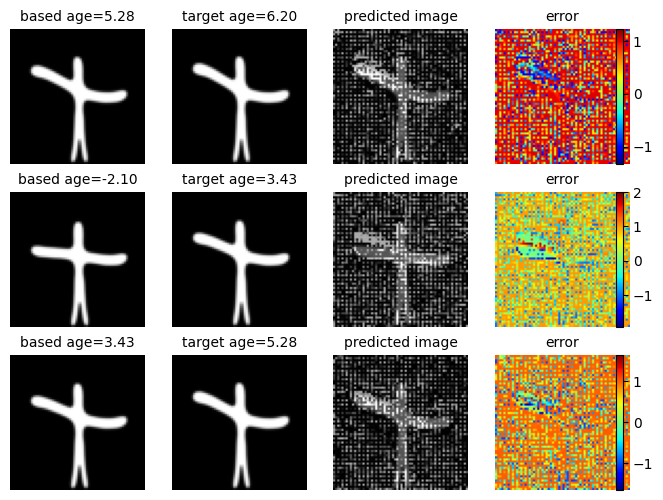

In [203]:
eval_dict_random_pair = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

eval_dict_random_pair, fig = tadm_test_step_random_pair(self, batch, eval_dict_random_pair, return_fig=True, nb_pair=3)

eval_dict_random_pair

## Test recon from the first image

tensor([-3.3200, -2.1100, -0.9000,  0.3200,  1.5300,  2.7400,  3.9600,  5.1700,
         6.3800,  7.6000])


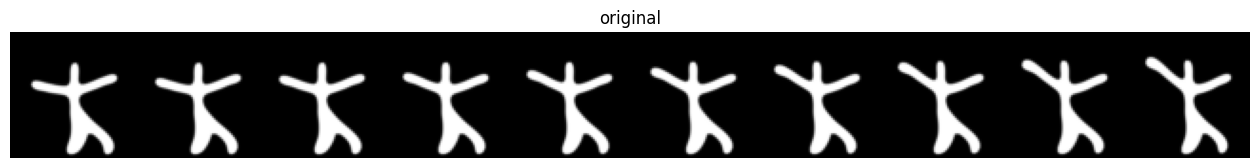

In [44]:
x0 = batch["x_origin"].squeeze(0)
quick_plot_tensor(x0, "original")

ages = batch["age"].squeeze()
print(ages)

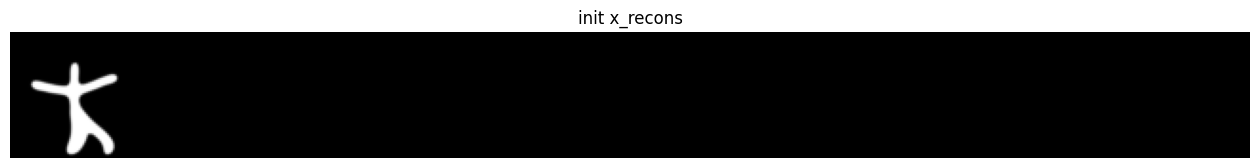

In [45]:
x_recons = torch.zeros_like(x0)
x_recons[0] = x0[0]
quick_plot_tensor(x_recons, "init x_recons")
prev_x = x_recons[0]
prev_age = ages[0]



In [46]:
# Reconstruct the whole sequence

for i, x in enumerate(x_recons):
    if i == 0:
        continue
    else:
        prev_x = x_recons[i-1]
        prev_age = ages[i-1]
        
        img_lr = prev_x.unsqueeze(0)
        diff_age = (ages[i] - prev_age).unsqueeze(0)

        # 1. encode image with RRDB
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim10",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age.unsqueeze(0),
            disable_tqdm=False,
        )

        x_recons[i] = (img_lr + x_pred).squeeze(0)


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 34.64it/s]


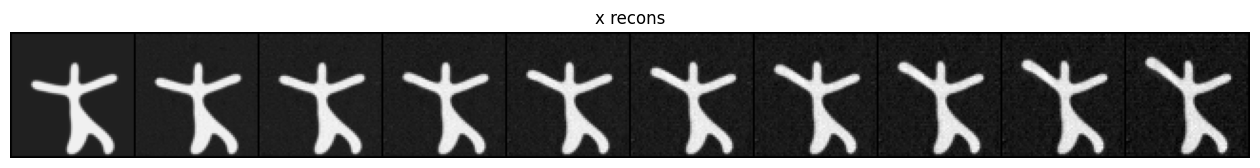

In [47]:
quick_plot_tensor(x_recons, "x recons")

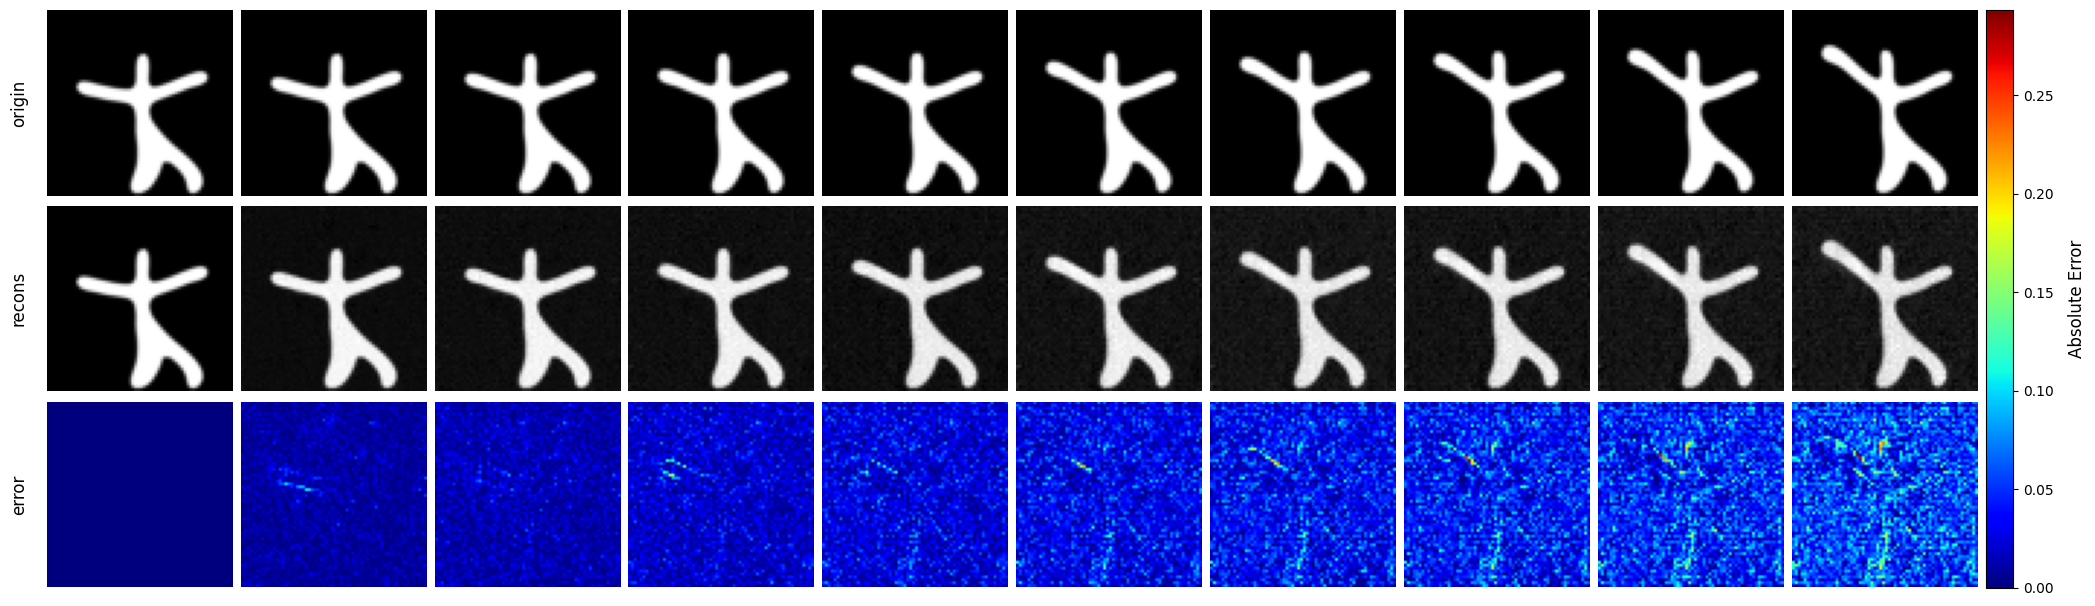

In [48]:
fig = plot_comparison_starmen(
    imgs=[x0.squeeze(), 
          x_recons.squeeze(),
          torch.abs(x0-x_recons).squeeze()],
    labels=["origin", "recons", "error"],
    is_errors=[False, False, True]
)

## Test with masked input

tensor([-2.1000, -1.1800, -0.2600,  0.6600,  1.5900,  2.5100,  3.4300,  4.3500,
         5.2800,  6.2000])


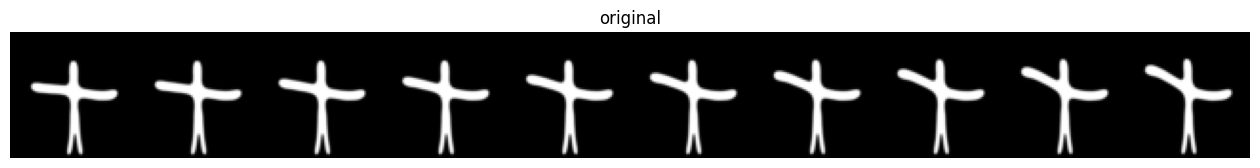

In [251]:
import random

x0 = batch["x_origin"].squeeze(0)
quick_plot_tensor(x0, "original")

ages = batch["age"].squeeze()
print(ages)

tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])


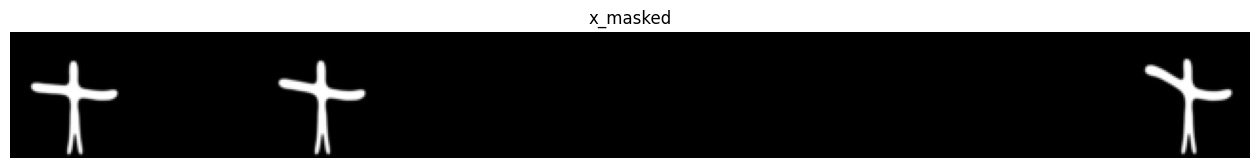

In [252]:
t, c, h, w = x0.shape

seen_mask = torch.full((t,), 0.)
perc_seen = 0.3
nb_seen = int(perc_seen * t)

seen_idxs = torch.randperm(t - 1)[:nb_seen-1] + 1
seen_mask[seen_idxs] = 1.
seen_mask[0] = 1.

# # only recons from the 1st image
# seen_mask[1:] = 0.

print(seen_mask)

x_masked = x0 * rearrange(seen_mask, "t -> t 1 1 1")
ages_masked = ages * seen_mask

quick_plot_tensor(x_masked, "x_masked")

In [253]:
x_recons = x_masked.clone()

prev_x = x_recons[0]

with torch.no_grad():
    for i, x in enumerate(x_recons):
        if seen_mask[i] == 1.:
            prev_x = x
            prev_age = ages[i]
        else:
            img_lr = prev_x.unsqueeze(0)

            diff_age = (ages[i] - prev_age).unsqueeze(0)
            print(diff_age)
            
            # 1. encode image with RRDB
            self.encoder.eval()
            rrdb_out, cond = self.encoder(img_lr, True)


            # 2. Sampling x from trained TADMUnet
            x_pred = self.gaussian_diffusion.regular_tadm_sample(
                ddim_style="ddim10",
                encoder=self.encoder,
                unet=self.decoder,
                x_0=img_lr,
                x_T=torch.randn_like(img_lr),
                z=cond,
                diff_ages=diff_age,
                ages=prev_age.unsqueeze(0),
                disable_tqdm=False,
            )

            # 3. Predict future image
            img_pred = (img_lr + x_pred).squeeze(0)
            x_recons[i] = img_pred
            prev_x = img_pred
            prev_age = ages[i]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.82it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.33it/s]


tensor([0.9300])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 32.07it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.18it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.35it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.87it/s]


tensor([0.9300])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 23.88it/s]


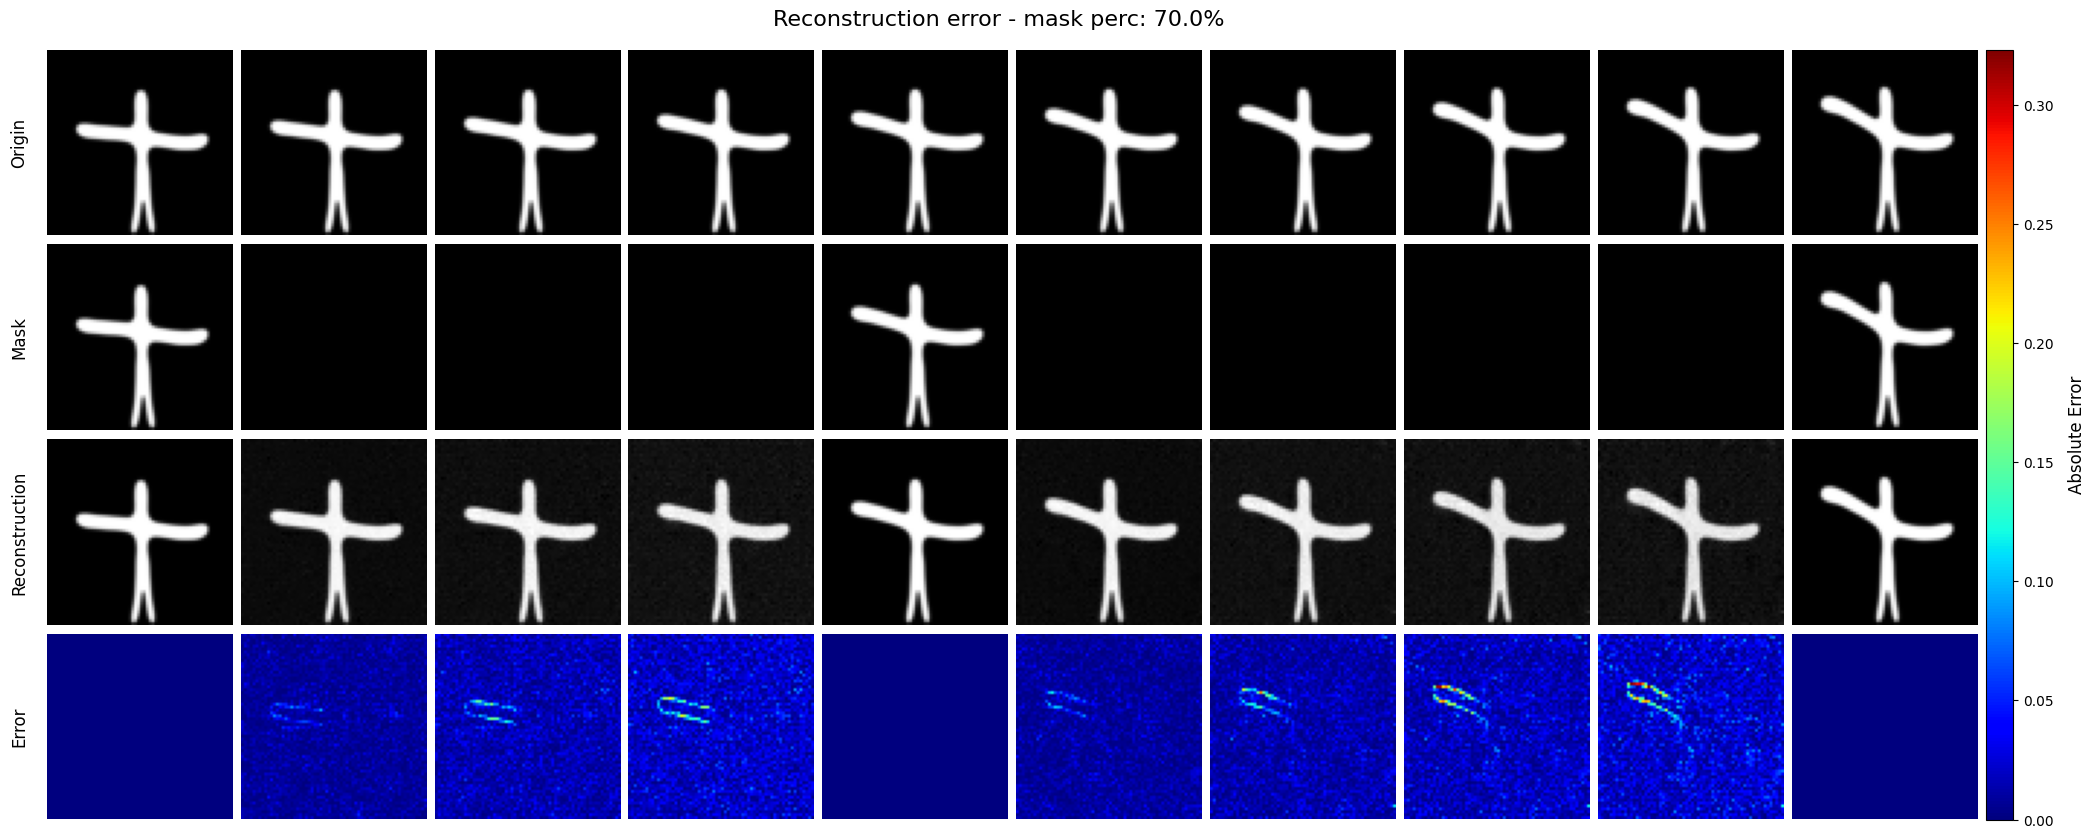

In [243]:
# Plot comparison
imgs = [
    x0.detach().cpu().squeeze(), 
    x_masked.detach().cpu().squeeze(),
    x_recons.detach().cpu().squeeze(),
    torch.abs(x0 - x_recons).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Mask",
    "Reconstruction",
    "Error"
]

opt = {
    "title": f"Reconstruction error - mask perc: {1 - perc_seen:.1%}"
}

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, False, True], opt=opt)

In [245]:
seen_mask.numpy().tolist()

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]

### function

In [261]:
@torch.no_grad()
def tadm_test_step_masked_input(self, batch, eval_dict, return_fig = False, perc_seen=0.2):
    """
    TADM test step using the previous scan as signal to predict the current scan
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"].squeeze(0)
    ages = batch["age"].squeeze()

    # generate mask
    t, c, h, w = x0.shape

    seen_mask = torch.full((t,), 0.)
    nb_seen = int(perc_seen * t)

    seen_idxs = torch.randperm(t - 1)[:nb_seen-1] + 1
    seen_mask[seen_idxs] = 1.
    seen_mask[0] = 1.

    x_masked = x0 * rearrange(seen_mask, "t -> t 1 1 1")
    ages_masked = ages * seen_mask

    # Generate the whole sequence from masked input
    x_recons = x_masked.clone()
    prev_x = x_recons[0]

    for i, x in enumerate(x_recons):
        if seen_mask[i] == 1.:
            prev_x = x
            prev_age = ages[i]
        else:
            img_lr = prev_x.unsqueeze(0)

            diff_age = (ages[i] - prev_age).unsqueeze(0)
            print(diff_age)
            
            # 1. encode image with RRDB
            self.encoder.eval()
            rrdb_out, cond = self.encoder(img_lr, True)


            # 2. Sampling x from trained TADMUnet
            x_pred = self.gaussian_diffusion.regular_tadm_sample(
                ddim_style="ddim10",
                encoder=self.encoder,
                unet=self.decoder,
                x_0=img_lr,
                x_T=torch.randn_like(img_lr),
                z=cond,
                diff_ages=diff_age,
                ages=prev_age.unsqueeze(0),
                disable_tqdm=False,
            )

            # 3. Predict future image
            img_pred = (img_lr + x_pred).squeeze(0)
            x_recons[i] = img_pred
            prev_x = img_pred
            prev_age = ages[i]

    # Calculate eval metrics
    img_pred = x_recons[seen_mask == 0.]
    img_hr = x0[seen_mask == 0.]

    ssim_metric = self.ssim(img_pred, img_hr).mean().item()
    mssim_metric = self.mssim(img_pred, img_hr).mean().item()
    psnr_metric = self.psnr(img_pred, img_hr).mean().item()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
    lpips_metric = self.lpips(img_pred, img_hr).item()

    # write to eval dict
    eval_dict["ids"].append(pidx)
    # eval_dict["ages"].append(ages.cpu().numpy())
    # eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
    eval_dict["perc_seen"].append(perc_seen)
    eval_dict["mask"].append(seen_mask.numpy().tolist())
    eval_dict["ssim_metric"].append(ssim_metric)
    eval_dict["mssim_metric"].append(mssim_metric)
    eval_dict["psnr_metric"].append(psnr_metric)
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err)
    eval_dict["l2err"].append(l2err)

    # Plot comparison
    if return_fig: 
        # Plot comparison
        imgs = [
            x0.detach().cpu().squeeze(), 
            x_masked.detach().cpu().squeeze(),
            x_recons.detach().cpu().squeeze(),
            torch.abs(x0 - x_recons).detach().cpu().squeeze(),
        ]

        labels = [
            "Origin",
            "Mask",
            "Reconstruction",
            "Error"
        ]
        opt = {
            "title": f"Reconstruction error - mask %: {perc_seen}"
        }

        fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, False, True], opt=opt)
        return eval_dict, fig
    else:
        return eval_dict

In [345]:
perc_seen_list = np.arange(0.1, 0.6, 0.1)
perc_seen_list
for p in perc_seen_list:
    print(p)

0.1
0.2
0.30000000000000004
0.4
0.5


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.49it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 32.29it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


tensor([0.9300])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.30it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.46it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 32.13it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 23.73it/s]


tensor([0.9300])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.75it/s]


tensor([0.9200])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 29.68it/s]


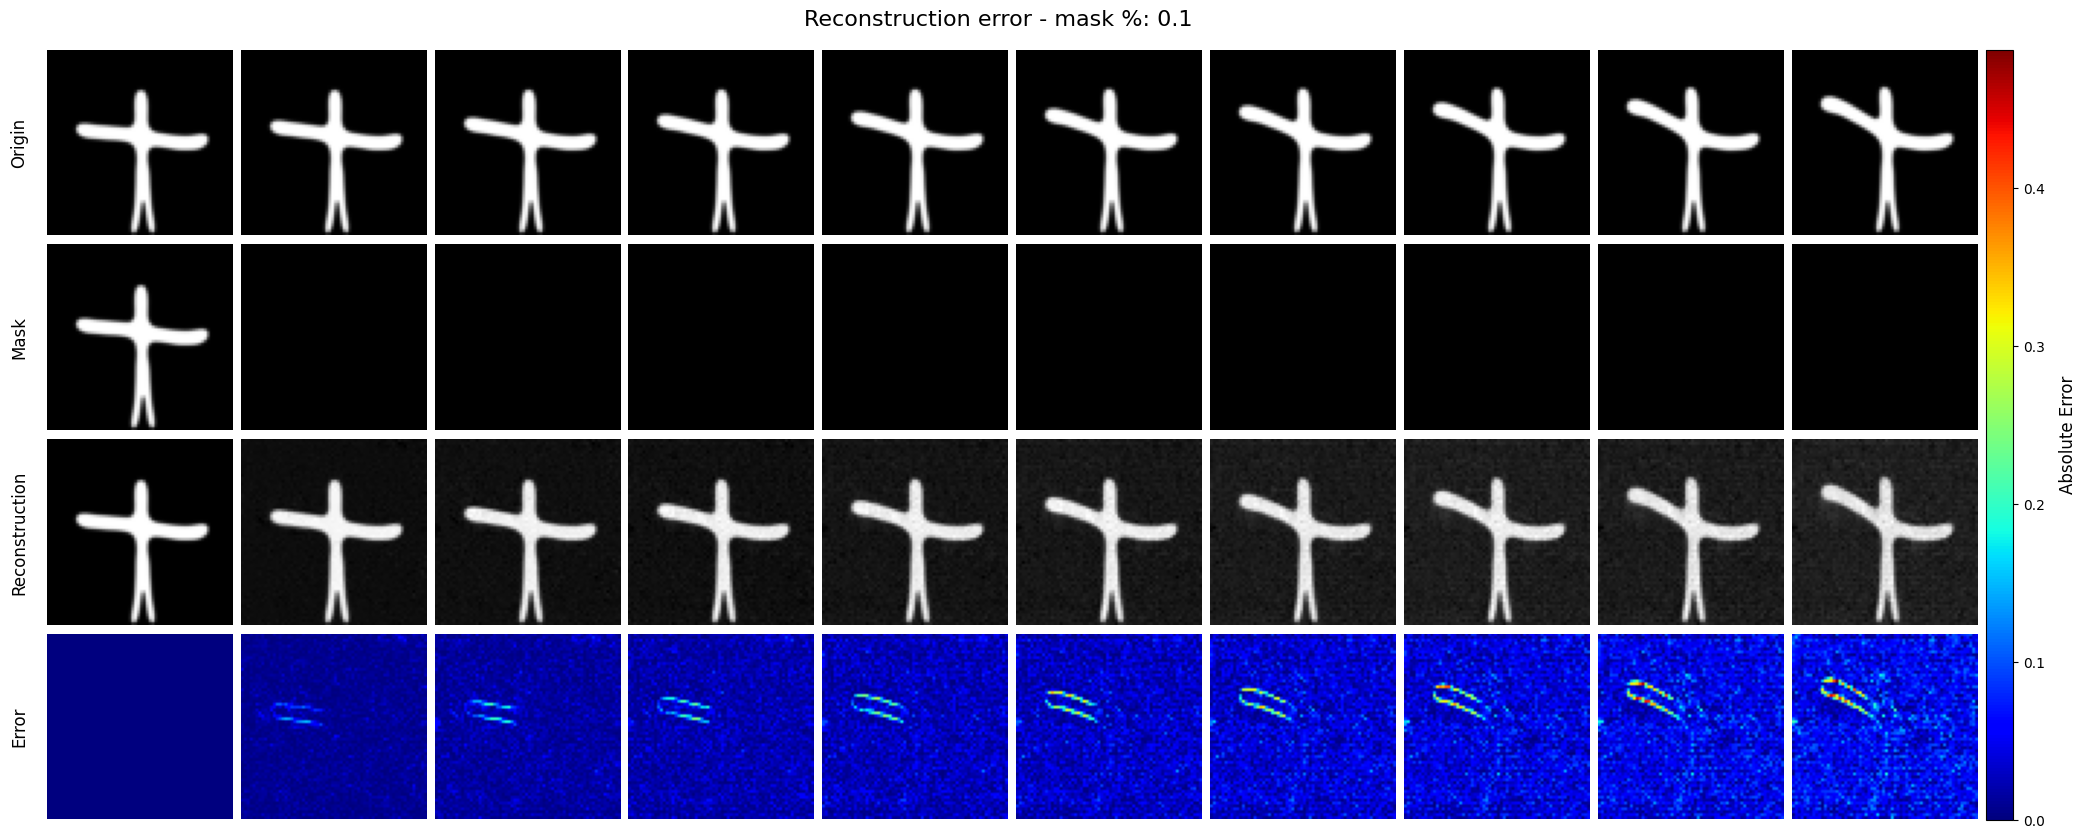

In [262]:
eval_dict_masked_input = {
    "ids": [],
    "mask": [],
    "perc_seen": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

x_recons, *out = tadm_test_step_masked_input(self, batch, eval_dict=eval_dict_masked_input, perc_seen=0.1, return_fig=True)

In [263]:
eval_dict_masked_input

{'ids': [184],
 'mask': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 'perc_seen': [0.1],
 'ages': [],
 'diff_ages': [],
 'ssim_metric': [0.3337475657463074],
 'mssim_metric': [0.9550416469573975],
 'psnr_metric': [28.15851593017578],
 'l1err': [0.03324117884039879],
 'l2err': [0.0021560401655733585],
 'lpips_metric': [0.1285429447889328]}

## Oversample

In [328]:
x0 = batch["x_origin"].squeeze(0)
ages = batch["age"].squeeze()

ages.shape

torch.Size([10])

In [ ]:
img_lr = x0[9].unsqueeze(0)
img_lr.shape
prev_age = ages[9].unsqueeze(0)
prev_age

oversample_step = 7
x_oversample = torch.zeros((oversample_step, 1, 64, 64))

with torch.no_grad():
    for i in range(oversample_step):
        diff_age = torch.tensor([1.])
        print(diff_age)
        
        # 1. encode image with RRDB
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim50",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age,
            disable_tqdm=False,
        )

        # 3. Predict future image
        img_pred = (img_lr + x_pred)
        x_oversample[i] = img_pred.squeeze(0)
        img_lr = img_pred
        prev_age += diff_age



tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 32.29it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 32.70it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 31.60it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


In [276]:
x_oversample.shape

torch.Size([7, 1, 64, 64])

Text(0.5, 0.95, 'Oversample - idx: 184 - increasing timestep: 1.')

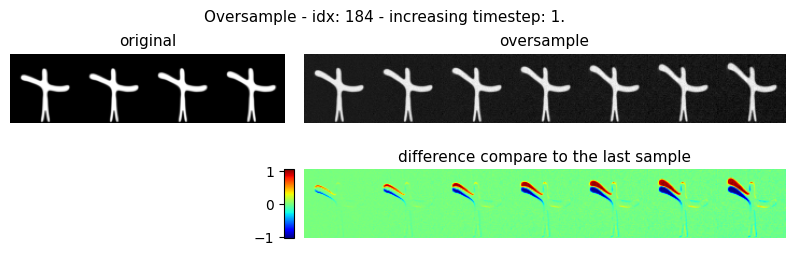

In [339]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(2, 2, 
                       figure=fig,
                       width_ratios=[4, 7], 
                       height_ratios=[1, 1] )

fig.subplots_adjust(
    # left=0.05, right=0.95,  # shrink/grow figure margins
    # bottom=0.1, top=1.0,
    wspace=0.05, hspace=0.0  # spacing between subplots
)

ax1 = fig.add_subplot(gs[0, 0])    
ax2 = fig.add_subplot(gs[0, 1])     
ax3 = fig.add_subplot(gs[1, 1])     
# ax_cb = fig.add_subplot(gs[1, 0]) 

# original sequence
img = x0[6:]
img = rearrange(img, "b c h w -> h (b c w)")
ax1.imshow(img, cmap="gray") 
ax1.axis("off")
ax1.set_title("original")

# oversample sequence
img = rearrange(x_oversample, "b c h w -> h (b c w)")
ax2.imshow(img, cmap="gray") 
ax2.axis("off")
ax2.set_title("oversample")

# difference
img = x_oversample - x0[-1]
img = rearrange(img, "b c h w -> h (b c w)")
im = ax3.imshow(img, cmap="jet") 
ax3.axis("off")
ax3.set_title("difference compare to the last sample")


bbox = ax3.get_position()  # [x0, y0, width, height] in figure coords
cax = fig.add_axes([bbox.x0 - 0.02, bbox.y0, 0.01, bbox.height])  
# [left, bottom, width, height] in figure coordinates

cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

for ax in fig.get_axes():  # get all axes in the figure
    ax.title.set_fontsize(11)
fig.suptitle(f"Oversample - idx: {pidx} - increasing timestep: 1.", fontsize=11, y=0.95)

# plt.tight_layout()

### function

In [341]:
@torch.no_grad()
def tadm_test_step_oversample(self, batch, oversample_step=7):
    """
    TADM test step with oversample from the last sample
    """

    # subject metadata
    pidx = batch["id"].item()

    x0 = batch["x_origin"].squeeze(0)
    ages = batch["age"].squeeze()

    # Start from the last 
    img_lr = x0[9].unsqueeze(0)
    img_lr.shape
    prev_age = ages[9].unsqueeze(0)
    prev_age

    x_oversample = torch.zeros((oversample_step, 1, 64, 64))

    for i in range(oversample_step):
        diff_age = torch.tensor([1.])
        print(diff_age)
        
        # 1. encode image with RRDB
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim10",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age,
            disable_tqdm=False,
        )

        # 3. Predict future image
        img_pred = (img_lr + x_pred)
        x_oversample[i] = img_pred.squeeze(0)
        img_lr = img_pred
        prev_age += diff_age
    
    # Plot
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(2, 2, 
                        figure=fig,
                        width_ratios=[4, 7], 
                        height_ratios=[1, 1] )

    fig.subplots_adjust(
        # left=0.05, right=0.95,  # shrink/grow figure margins
        # bottom=0.1, top=1.0,
        wspace=0.05, hspace=0.0  # spacing between subplots
    )

    ax1 = fig.add_subplot(gs[0, 0])    
    ax2 = fig.add_subplot(gs[0, 1])     
    ax3 = fig.add_subplot(gs[1, 1])     
    # ax_cb = fig.add_subplot(gs[1, 0]) 

    # original sequence
    img = x0[6:]
    img = rearrange(img, "b c h w -> h (b c w)")
    ax1.imshow(img, cmap="gray") 
    ax1.axis("off")
    ax1.set_title("original")

    # oversample sequence
    img = rearrange(x_oversample, "b c h w -> h (b c w)")
    ax2.imshow(img, cmap="gray") 
    ax2.axis("off")
    ax2.set_title("oversample")

    # difference
    img = x_oversample - x0[-1]
    img = rearrange(img, "b c h w -> h (b c w)")
    im = ax3.imshow(img, cmap="jet") 
    ax3.axis("off")
    ax3.set_title("difference compare to the last sample")


    bbox = ax3.get_position()  # [x0, y0, width, height] in figure coords
    cax = fig.add_axes([bbox.x0 - 0.02, bbox.y0, 0.01, bbox.height])  
    # [left, bottom, width, height] in figure coordinates

    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

    for ax in fig.get_axes():  # get all axes in the figure
        ax.title.set_fontsize(11)
    fig.suptitle(f"Oversample - idx: {pidx} - increasing timestep: 1.", fontsize=11, y=0.95)
    return fig


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.71it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 23.38it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 32.41it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.48it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 33.56it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.14it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.49it/s]


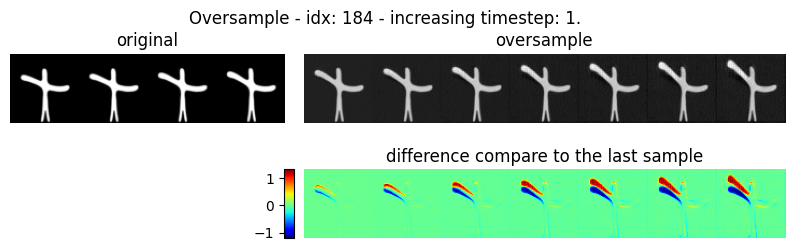

In [340]:
fig = tadm_test_step_oversample(self, batch, oversample_step=5)